In [38]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')

from langchain_openai import ChatOpenAI

# Create the OpenAI LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", temperature=0, streaming=True)

## SQL models

In [39]:
from sqlalchemy import create_engine, Column, Integer, String, Float, DateTime, Date
from sqlalchemy.orm import sessionmaker, declarative_base, Session
import datetime
import logging

# Database URL and Base declarative class
SQLALCHEMY_DATABASE_URL = 'sqlite:///./api_data.db'
Base = declarative_base()

# Define the ElectricityData model
class ElectricityData(Base):
    __tablename__ = 'electricity_prices'
    id = Column(Integer, primary_key=True, index=True)
    city = Column(String, index=True)
    state = Column(String, index=True)
    date = Column(Date, index=True)
    region = Column(String, index=True)
    NOK_per_kWh = Column(Float)
    EUR_per_kWh = Column(Float)
    EXR = Column(Float)
    time_start = Column(String)
    time_end = Column(String)
    timestamp = Column(DateTime, default=datetime.datetime.now(datetime.timezone.utc))

# Define the WeatherData model
class WeatherData(Base):
    __tablename__ = 'weather_data'
    id = Column(Integer, primary_key=True, index=True)
    city = Column(String, index=True)
    state = Column(String, index=True)
    date = Column(Date, index=True)
    temperature = Column(Float)
    time_start = Column(String)
    time_end = Column(String)
    timestamp = Column(DateTime, default=datetime.datetime.now(datetime.timezone.utc))


# Create the database and tables
def create_database():
    engine = create_engine(SQLALCHEMY_DATABASE_URL)
    Base.metadata.create_all(bind=engine)
    print("Database and tables created.")

# Drop all tables in the database
def reset_database():
    engine = create_engine(SQLALCHEMY_DATABASE_URL)
    Base.metadata.drop_all(bind=engine)
    Base.metadata.create_all(bind=engine)
    print("Database reset complete.")

# Custom session to handle API fetching if data is missing
class CustomSession(Session):
    def query_with_api(self, model, request):
        try:
            # Attempt to retrieve data from the database
            result = self.query(model).filter_by(**request).all()
            if result:
                return result
            else:
                raise NoResultFound
        except NoResultFound:
            # If data is not found, fetch from the API and store it
            if model == ElectricityData:
                tool = ElectricityPriceTool(self)
                tool.get_electricity_prices(request)
            elif model == WeatherData:
                tool = WeatherDataTool(self)
                tool.get_weather_data(request)
            # Attempt to retrieve data again after fetching from the API
            result = self.query(model).filter_by(**request).all()
            return result


def get_db():
    # Use the custom session
    engine = create_engine(SQLALCHEMY_DATABASE_URL)
    SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine, class_=CustomSession)
    try:
        db = SessionLocal()
        yield db
    finally:
        db.close()

def store_data(db, model, data):
    for item in data:
        item['date'] = datetime.strptime(item['date'], '%Y-%m-%d').date()  # Correct usage
        db_item = model(**item)
        db.add(db_item)
    db.commit()

# Example usage to reset the database
if __name__ == "__main__":
    reset_database()  # Resets the database (drops and recreates tables)

Database reset complete.


## Pydantic models

In [40]:
# schemas.py
from pydantic import BaseModel, Field
from typing import List

class ElPriceResponse(BaseModel):
    NOK_per_kWh: float
    EUR_per_kWh: float
    EXR: float
    time_start: str
    time_end: str

    class Config:
        from_attributes = True

class ElPriceRequest(BaseModel):
    city: str = Field(description="City")
    state: str = Field(description="State or region")
    date: str = Field(description="Date query ('YYYY-MM-DD/YYYY-MM-DD')")

# Pydantic models
class WeatherDataResponse(BaseModel):
    temperature: float
    time_start: str
    time_end: str

    class Config:
        from_attributes = True

class WeatherRequest(BaseModel):
    city: str = Field(description="City")
    state: str = Field(description="State or region")
    date: str = Field(description="Date query (YYYY-MM-DD/YYYY-MM-DD')")

## Tools

In [41]:
from typing import Any, Dict, List, Optional, Tuple
from datetime import datetime, timedelta
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import requests_cache
import openmeteo_requests
import pandas as pd
from sqlalchemy.orm import Session
from functools import lru_cache
from retry_requests import retry

# Utility function to parse date ranges
def parse_date(date: str) -> Tuple[datetime, datetime]:
    try:
        if '/' in date:
            start_date_str, end_date_str = date.split('/')
            start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
            end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
        else:
            start_date = end_date = datetime.strptime(date, '%Y-%m-%d')

        if start_date > end_date:
            raise ValueError("Start date cannot be after end date.")

        return start_date, end_date
    except ValueError as e:
        raise ValueError(f"Invalid date format: {date}. Expected format is YYYY-MM-DD or YYYY-MM-DD/YYYY-MM-DD. Error: {str(e)}")


# Base class to handle common methods
class BaseDataTool:
    geolocator = Nominatim(user_agent="data_tool_api")

    def __init__(self, db: Session):
        self.db = db

    @lru_cache(maxsize=100)
    def get_coordinates(self, city_name: str, state: str) -> Optional[Tuple[float, float]]:
        location = self.geolocator.geocode(f"{city_name}, {state}")
        return (location.latitude, location.longitude) if location else None


# Tool to fetch electricity prices
class ElectricityPriceTool(BaseDataTool):
    REGIONS = {
        "NO1": ("Oslo", (59.9139, 10.7522)),
        "NO2": ("Kristiansand", (58.1467, 7.9956)),
        "NO3": ("Trondheim", (63.4305, 10.3951)),
        "NO4": ("Tromsø", (69.6492, 18.9553)),
        "NO5": ("Bergen", (60.3928, 5.3221)),
    }

    session = requests_cache.CachedSession('electricity_cache', expire_after=86400)

    def find_nearest_region(self, lat: float, lon: float) -> Optional[str]:
        nearest_region = min(
            self.REGIONS.items(),
            key=lambda region: geodesic((lat, lon), region[1][1]).kilometers
        )[0]
        return nearest_region

    def fetch_electricity_prices(self, date: str, region: str) -> list:
        year, month, day = date.split('-')
        url = f"https://www.hvakosterstrommen.no/api/v1/prices/{year}/{month}-{day}_{region}.json"
        response = self.session.get(url)
        
        if response.status_code == 200:
            return response.json()
        return {"error": f"Error fetching data: {response.status_code}"}

    def store_prices(self, request: Dict[str, Any], region: str, prices: list):
        data = [
            {
                "city": request['city'],
                "state": request['state'],
                "date": datetime.strptime(request['date'], '%Y-%m-%d').date(),
                "region": region,
                "NOK_per_kWh": price["NOK_per_kWh"],
                "EUR_per_kWh": price["EUR_per_kWh"],
                "EXR": price["EXR"],
                "time_start": datetime.fromisoformat(price["time_start"]),
                "time_end": datetime.fromisoformat(price["time_end"])
            }
            for price in prices
        ]
        
        self.db.bulk_save_objects([ElectricityData(**entry) for entry in data])
        self.db.commit()

    def get_electricity_prices(self, request: Dict[str, Any]) -> List[Dict[str, Any]]:
        coordinates = self.get_coordinates(request['city'], request['state'])
        if not coordinates:
            return {"error": "City not found"}

        lat, lon = coordinates
        start_date, end_date = parse_date(request['date'])
        nearest_region = self.find_nearest_region(lat, lon)
        all_prices = []

        if nearest_region:
            current_date = start_date
            while current_date <= end_date:
                date_str = current_date.strftime('%Y-%m-%d')
                prices = self.fetch_electricity_prices(date_str, nearest_region)
                if isinstance(prices, list):
                    self.store_prices({**request, 'date': date_str}, nearest_region, prices)
                    all_prices.extend(prices)
                current_date += timedelta(days=1)

            return all_prices if all_prices else {"error": "No data found for the given date range."}

        return {"error": "Could not determine the nearest region."}


class WeatherDataTool(BaseDataTool):
    cache_session = requests_cache.CachedSession('.weather_cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    def store_weather_data(self, request: Dict[str, Any], observations: list):
        data = [
            {
                "city": request['city'],
                "state": request['state'],
                "date": datetime.strptime(observation['date'], '%Y-%m-%d').date(),
                "temperature": observation['temperature'],
                "time_start": datetime.fromisoformat(observation['time_start']),
                "time_end": datetime.fromisoformat(observation['time_end']),
            }
            for observation in observations
        ]
        self.db.bulk_save_objects([WeatherData(**entry) for entry in data])
        self.db.commit()

    def get_weather_data(self, request: Dict[str, Any]) -> List[Dict[str, Any]]:
        coordinates = self.get_coordinates(request['city'], request['state'])
        if not coordinates:
            return {"error": "Could not find coordinates for the specified city and state."}

        latitude, longitude = coordinates
        start_date, end_date = parse_date(request['date'])

        all_observations = []
        current_date = start_date

        while current_date <= end_date:
            date_str = current_date.strftime('%Y-%m-%d')
            params = {
                "latitude": latitude,
                "longitude": longitude,
                "start_date": date_str,
                "end_date": date_str,
                "hourly": "temperature_2m"
            }
            response = self.openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)[0]

            hourly = response.Hourly()
            hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

            hourly_dates = pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left"
            ).strftime('%Y-%m-%dT%H:%M:%S%z')

            observations = [
                {
                    "date": date_str,
                    "temperature": float(hourly_temperature_2m[i]),
                    "time_start": hourly_dates[i],
                    "time_end": hourly_dates[i + 1]
                }
                for i in range(len(hourly_dates) - 1)
            ]

            all_observations.extend(observations)
            current_date += timedelta(days=1)

        self.store_weather_data(request, all_observations)

        return all_observations


# Example request for electricity prices
def get_all_electricity_prices(db: Session, electricity_request: Dict[str, Any]) -> List[Dict[str, Any]]:
    tool = ElectricityPriceTool(db)
    return tool.get_electricity_prices(electricity_request)


# Example request for weather data
def get_all_weather_data(db: Session, weather_request: Dict[str, Any]) -> List[Dict[str, Any]]:
    tool = WeatherDataTool(db)
    return tool.get_weather_data(weather_request)


In [42]:
from sqlalchemy.orm.exc import NoResultFound

# Example usage
db = next(get_db())

# Example request for electricity prices
electricity_request = {
    "city": "Lillehammer",
    "state": "Oslo",
    "date": "2024-01-01/2024-10-02"
}

# Retrieve all electricity prices with automatic API fetching if necessary
all_prices = get_all_electricity_prices(db, electricity_request)
print(all_prices)

# Example request for weather data
weather_request = {
    "city": "Lillehammer",
    "state": "Lillehammer",
    "date": "2023-07-23/2023-07-25"
}

# Retrieve all weather data with automatic API fetching if necessary
all_weather = get_all_weather_data(db, weather_request)
print(all_weather)

db.close()

[{'NOK_per_kWh': 0.60463, 'EUR_per_kWh': 0.05379, 'EXR': 11.2405, 'time_start': '2024-01-01T00:00:00+01:00', 'time_end': '2024-01-01T01:00:00+01:00'}, {'NOK_per_kWh': 0.55056, 'EUR_per_kWh': 0.04898, 'EXR': 11.2405, 'time_start': '2024-01-01T01:00:00+01:00', 'time_end': '2024-01-01T02:00:00+01:00'}, {'NOK_per_kWh': 0.30855, 'EUR_per_kWh': 0.02745, 'EXR': 11.2405, 'time_start': '2024-01-01T02:00:00+01:00', 'time_end': '2024-01-01T03:00:00+01:00'}, {'NOK_per_kWh': 0.27517, 'EUR_per_kWh': 0.02448, 'EXR': 11.2405, 'time_start': '2024-01-01T03:00:00+01:00', 'time_end': '2024-01-01T04:00:00+01:00'}, {'NOK_per_kWh': 0.26988, 'EUR_per_kWh': 0.02401, 'EXR': 11.2405, 'time_start': '2024-01-01T04:00:00+01:00', 'time_end': '2024-01-01T05:00:00+01:00'}, {'NOK_per_kWh': 0.23864, 'EUR_per_kWh': 0.02123, 'EXR': 11.2405, 'time_start': '2024-01-01T05:00:00+01:00', 'time_end': '2024-01-01T06:00:00+01:00'}, {'NOK_per_kWh': 0.25426, 'EUR_per_kWh': 0.02262, 'EXR': 11.2405, 'time_start': '2024-01-01T06:00:00

In [43]:
from langchain_core.tools import tool
from typing import Dict, Any, List


def process_electricity_prices(prices: List[ElPriceResponse]):
    if all(isinstance(price, dict) for price in prices):
        return prices
    else:
        return [price.dict() for price in prices]


def process_weather_data(data: List[WeatherDataResponse]) -> List[Dict[str, Any]]:
    if all(isinstance(item, dict) for item in data):
        return data
    else:    
        return [item.dict() for item in data]

def query_electricity_prices(db: Session, city: str, state: str, date: str) -> List[Dict[str, Any]]:
    prices = get_all_electricity_prices(db, {"city": city, "state": state, "date": date})
    # Convert to a list of dictionaries
    return process_electricity_prices(prices)

def query_weather_data(db: Session, city: str, state: str, date: str) -> List[Dict[str, Any]]:
    request = {"city": city, "state": state, "date": date}
    weather_data = get_all_weather_data(db, request)
    return process_weather_data(weather_data)

@tool
def electricity_price_tool(city: str, state: str, date: str) -> List[Dict[str, Any]]:
    """
    Fetches electricity prices for a given city, state, and date query.

    """
    with next(get_db()) as db:
        prices = query_electricity_prices(db, city, state, date)
    return prices

@tool
def weather_data_tool(city: str, state: str, date: str) -> List[Dict[str, Any]]:
    """
    Fetches weather data for a given city, state, and date query.

    """
    with next(get_db()) as db:
        weather_data = query_weather_data(db, city, state, date)
    return weather_data


# Fishing tools (data retrieval)
fishing_tools = [electricity_price_tool, weather_data_tool]

In [44]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities.sql_database import SQLDatabase

engine = create_engine(SQLALCHEMY_DATABASE_URL)
db = SQLDatabase(engine)

# Assuming `db` is your database session and `llm` is your language model
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

# SQL tools (data analysis)
sql_tools = toolkit.get_tools()

## Statistical tools

In [45]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sqlalchemy.orm import Session
from typing import Dict, Any, List

# Fetch electricity prices and convert to DataFrame
def query_el_to_df(db: Session, electricity_request: Dict[str, Any]) -> pd.DataFrame:
    data = get_all_electricity_prices(db, electricity_request)
    df = pd.DataFrame(data)
    return df

# Fetch weather data and convert to DataFrame
def query_weather_to_df(db: Session, weather_request: Dict[str, Any]) -> pd.DataFrame:
    data = get_all_weather_data(db, weather_request)
    df = pd.DataFrame(data)
    return df

def correlation_analysis(db: Session, electricity_request: Dict[str, Any], weather_request: Dict[str, Any]) -> float:
    electricity_df = query_el_to_df(db, electricity_request)
    weather_df = query_weather_to_df(db, weather_request)
    
    correlation = electricity_df['NOK_per_kWh'].corr(weather_df['temperature'])
    
    return correlation

def descriptive_statistics(db: Session, electricity_request: Dict[str, Any], weather_request: Dict[str, Any]) -> Dict[str, pd.DataFrame]:
    electricity_df = query_el_to_df(db, electricity_request)
    weather_df = query_weather_to_df(db, weather_request)
    
    electricity_stats = electricity_df.describe()
    weather_stats = weather_df.describe()
    
    return {"electricity_stats": electricity_stats, "weather_stats": weather_stats}

def regression_analysis(db: Session, electricity_request: Dict[str, Any], weather_request: Dict[str, Any]) -> str:
    electricity_df = query_el_to_df(db, electricity_request)
    weather_df = query_weather_to_df(db, weather_request)
    
    merged_df = pd.merge(electricity_df, weather_df, on=['city', 'state', 'date'])
    
    merged_df['date_numeric'] = pd.to_datetime(merged_df['date']).map(pd.Timestamp.timestamp)
    
    X = merged_df['date_numeric']
    
    Y_temp = merged_df['temperature']
    Y_price = merged_df['NOK_per_kWh']
    
    X = sm.add_constant(X)
    
    model_temp = sm.OLS(Y_temp, X).fit()
    model_price = sm.OLS(Y_price, X).fit()
    
    summary_temp = f"Temperature Regression:\nR-squared: {model_temp.rsquared:.4f}, p-value: {model_temp.f_pvalue:.4f}\n"
    summary_price = f"Electricity Price Regression:\nR-squared: {model_price.rsquared:.4f}, p-value: {model_price.f_pvalue:.4f}\n"
    
    return f"{summary_temp}\n{summary_price}"



@tool
def descriptive_stats_tool(city: str, state: str, date: str) -> Dict[str, pd.DataFrame]:
    """
    Computes descriptive statistics for electricity prices and weather data.

    Args:
        city (str): The city for which the data is requested.
        state (str): The state or region for the requested city.
        date (str): The date or date range in 'YYYY-MM-DD' or 'YYYY-MM-DD/YYYY-MM-DD' format.

    Returns:
        Dict[str, pd.DataFrame]: A dictionary containing descriptive statistics for electricity prices 
        and weather data, with keys 'electricity_stats' and 'weather_stats' respectively.
    """
    with next(get_db()) as db:
        electricity_request = {"city": city, "state": state, "date": date}
        weather_request = {"city": city, "state": state, "date": date}
        stats = descriptive_statistics(db, electricity_request, weather_request)
    return stats


@tool
def correlation_tool(city: str, state: str, date: str) -> float:
    """
    Calculates the correlation between electricity prices and temperature.

    Args:
        city (str): The city for which the data is requested.
        state (str): The state or region for the requested city.
        date (str): The date or date range in 'YYYY-MM-DD' or 'YYYY-MM-DD/YYYY-MM-DD' format.

    Returns:
        float: The correlation coefficient between electricity prices (NOK_per_kWh) and temperature.
    """
    with next(get_db()) as db:
        electricity_request = {"city": city, "state": state, "date": date}
        weather_request = {"city": city, "state": state, "date": date}
        correlation = correlation_analysis(db, electricity_request, weather_request)
    return correlation


@tool
def regression_tool(city: str, state: str, date: str) -> str:
    """
    Performs a linear regression analysis on the relationship between electricity prices and temperature.

    Args:
        city (str): The city for which the data is requested.
        state (str): The state or region for the requested city.
        date (str): The date or date range in 'YYYY-MM-DD' or 'YYYY-MM-DD/YYYY-MM-DD' format.

    Returns:
        str: A summary of the regression analysis as a formatted string.
    """
    with next(get_db()) as db:
        electricity_request = {"city": city, "state": state, "date": date}
        weather_request = {"city": city, "state": state, "date": date}
        regression_summary = regression_analysis(db, electricity_request, weather_request)
    return regression_summary


In [46]:
statistical_tools = [regression_tool, correlation_tool, descriptive_stats_tool]

In [47]:
tools = sql_tools + fishing_tools
llm_with_tools = llm.bind_tools(tools)

In [48]:
tools

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7b30493d4dd0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7b30493d4dd0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7b30493d4dd0>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [49]:
from sqlalchemy import create_engine, inspect

engine = create_engine(SQLALCHEMY_DATABASE_URL)

with engine.connect() as connection:
    inspector = inspect(engine)
    columns = inspector.get_columns('electricity_prices')
    print("Columns in 'electricity_prices' table:")
    for column in columns:
        print(column['name'])

Columns in 'electricity_prices' table:
id
city
state
date
region
NOK_per_kWh
EUR_per_kWh
EXR
time_start
time_end
timestamp


In [50]:
from langchain_core.messages import SystemMessage

system_prompt = SystemMessage(content="You are an AI that specializes in analyzing electricity prices and weather data. Your responses should be concise, data-driven, and insightful. Provide statistical analyses where relevant.")

In [51]:
response = llm.invoke([system_prompt])

In [52]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

# Step 1: Create the primary assistant prompt template
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant specializing in data analysis with a focus on electricity prices and weather data. "
            "Follow these steps to fulfill user requests:\n"
            "1. **Determine Data Requirements**: Understand the user's query and identify the type of data needed (e.g., electricity prices, weather data).\n"
            "2. **Check Data Availability**: Use the SQL tools to check if the required data is already available in the database.\n"
            "   - If data is available, fetch it using the SQL tools.\n"
            "   - If data is not available, use the appropriate fetching tools to obtain the data (e.g., electricity_price_tool, weather_data_tool).\n"
            "3. **Data Analysis**: Once data is obtained, determine the type of statistical analysis required by the user (e.g., descriptive statistics, correlation, regression).\n"
            "   - Use the descriptive_stats_tool for basic statistical summaries.\n"
            "   - Use the correlation_tool to analyze relationships between variables.\n"
            "   - Use the regression_tool for predictive modeling and to understand relationships between variables.\n"
            "4. **Provide Insightful Responses**: Offer concise, data-driven insights and visualizations as needed based on the analysis results. Always ensure your responses are clear, precise, and aligned with the user's query.",
        ),
        ("placeholder", "{messages}"),  # Placeholder to be replaced by actual user messages dynamically.
    ]
)


# Step 2: Bind tools to the LLM
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

In [53]:
from langchain_core.messages.tool import ToolMessage
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AIMessage
from langchain_core.runnables import (
    Runnable,
    RunnableLambda,
)


def create_tool_node_with_fallback(tools):
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def handle_tool_error(state):
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            AIMessage(
                content=f"Error: {repr(error)}. Please fix your mistakes.",
                tool_call_id=tc["id"]
            ) for tc in tool_calls
        ]
    }

tool_node_with_fallback = create_tool_node_with_fallback(tools)

In [54]:
from typing import Annotated, List

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.

        Args:
            runnable (Runnable): The runnable instance to invoke.
        """
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        """
        Call method to invoke the LLM and handle its responses.
        Re-prompt the assistant if the response is not a tool call or meaningful text.

        Args:
            state (State): The current state containing messages.
            config (RunnableConfig): The configuration for the runnable.

        Returns:
            dict: The final state containing the updated messages.
        """
        while True:
            result = self.runnable.invoke(state)  # Invoke the LLM
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [55]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import tools_condition

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
#memory = MemorySaver()
graph = builder.compile()

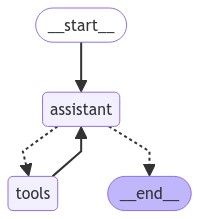

In [56]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [60]:
def process_input(input_text):
    # Streaming the response from the app based on input_text
    for chunk in graph.stream({"messages": [("human", input_text)]}, stream_mode="values"):
        chunk["messages"][-1].pretty_print()

# Example usage with a single input
process_input(" Can you fetch the electricity data in Trondheim in the period between 2024-01-01 and 2024-08-28. Calculate the average price each month")

================================ Human Message =================================

 Can you fetch the electricity data in Trondheim in the period between 2024-01-01 and 2024-08-28. Calculate the average price each month
================================== Ai Message ==================================
Tool Calls:
  electricity_price_tool (call_5YoYcsbYAMtvjtrAXIuJe4qC)
 Call ID: call_5YoYcsbYAMtvjtrAXIuJe4qC
  Args:
    city: Trondheim
    state: Norway
    date: 2024-01-01
================================= Tool Message =================================
Name: electricity_price_tool

[{"NOK_per_kWh": 0.33227, "EUR_per_kWh": 0.02956, "EXR": 11.2405, "time_start": "2024-01-01T00:00:00+01:00", "time_end": "2024-01-01T01:00:00+01:00"}, {"NOK_per_kWh": 0.3199, "EUR_per_kWh": 0.02846, "EXR": 11.2405, "time_start": "2024-01-01T01:00:00+01:00", "time_end": "2024-01-01T02:00:00+01:00"}, {"NOK_per_kWh": 0.29967, "EUR_per_kWh": 0.02666, "EXR": 11.2405, "time_start": "2024-01-01T02:00:00+01:00", "time